# Lens Modeling for DESIJ1539+1650

**Authors:** Zannat Chowdhury, Mir Sazzat Hossain, S M Rafee Adnan, Anowar J. Shajib

#### Importing the required packages

In [39]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence


#### Read the data file

In [40]:
with h5py.File("DESIJ1539+1650_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.013182383426603758
dec_at_xy_0: -9.23999999999999
exposure_time: [[490.90875 421.75388 439.10574 ... 486.56738 406.6674  548.1046 ]
 [447.409   503.6679  418.47308 ... 592.03424 454.74384 466.78656]
 [441.13593 567.0645  418.47824 ... 464.80774 433.77225 425.30106]
 ...
 [604.4732  476.06665 545.15735 ... 528.9927  497.26175 367.77853]
 [490.31616 330.20276 396.50378 ... 341.58386 422.0971  425.519  ]
 [451.5098  483.99115 520.6441  ... 475.88297 564.95496 522.05316]]
image_data: [[ 0.00067712 -0.01423318  0.00151635 ... -0.00029543 -0.00692246
  -0.0166516 ]
 [ 0.00363533 -0.00039791 -0.01873723 ...  0.01981123  0.00081102
   0.00612396]
 [-0.01712817 -0.00955698 -0.0194798  ...  0.00040743 -0.00297122
  -0.00672446]
 ...
 [ 0.00515814  0.00832129 -0.00283378 ... -0.00238547  0.00146614
  -0.00219803]
 [-0.00667532  0.00798152  0.00278799 ...  0.00431538  0.00754044
  -0.00536348]
 [-0.00077069  0.0147179   0.00402649 ... -0.00141456 -0.0080586
   0.00624329]]
ra_at_

#### Load PSF data


In [41]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}

    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


#### Get the image data from `kwargs_data` and plot it

/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_89177/1502520930.py:3: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


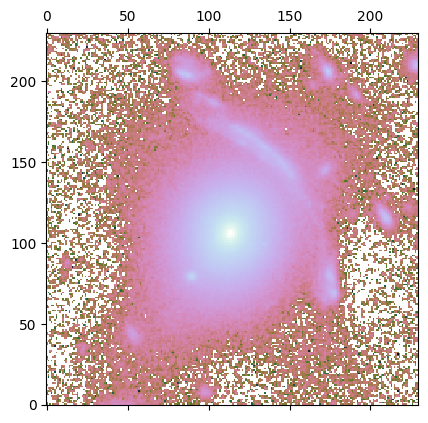

In [42]:
image_data = kwargs_data["image_data"]

plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

#### Make mask and plot it

/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_89177/3434977408.py:60: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_89177/3434977408.py:71: RuntimeWarning: divide by zero encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_89177/3434977408.py:71: RuntimeWarning: invalid value encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


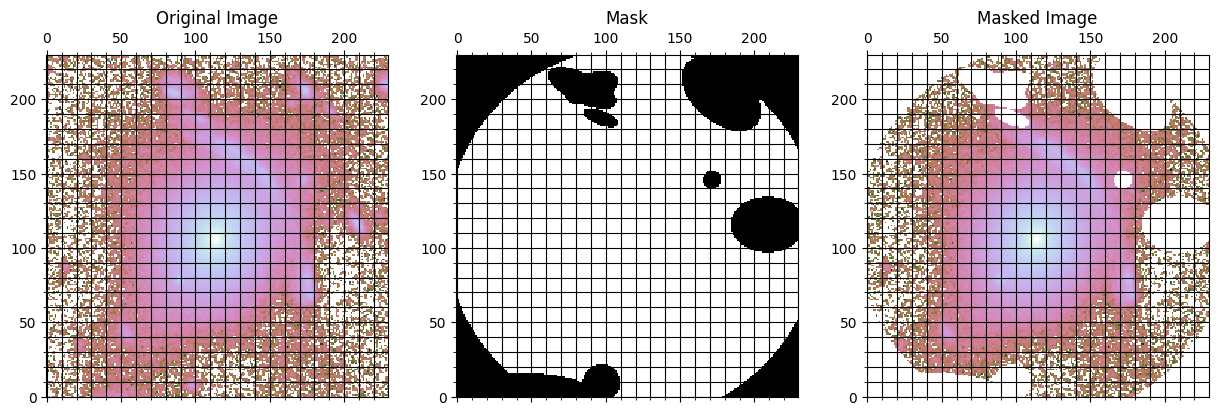

In [43]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 10  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.2,
    lens_center_dec - 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_params = [
    [-7.5, 0, 2, 1.5, -np.pi / 180 * 0],  # x, y, q, phi, theta
    [-5, 7, 1.5, 2.5,  -np.pi / 180 * 50],
    [-4.5, 2.4, 0.5, 0.5, 0],
    [2.5, 7.35, 2, 0.8, np.pi / 180 * 25],
    [2, 7.35, 1.5, 0.8, -np.pi / 180 * 20],
    [1.45, -8.5, 1, 1, 0],
    [5.5, -9, 3.5, 1, 0],
    [1.5, 5.75, 0.4, 1, -np.pi / 180 * 68],


    # [-1.6, 5, 2.8, 2, np.pi / 4],
    # [-6.28, 0, 2, 1, np.pi / 2],
]

mask = 1 - mask_outer

for mask_param in mask_params:
    mask *= 1 - mask_util.mask_ellipse(
        util.image2array(x_coords),
        util.image2array(y_coords),
        mask_param[0],
        mask_param[1],
        mask_param[2],
        mask_param[3],
        mask_param[4],
    )

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

# mask image data
masked_image_data = np.multiply(image_data, mask)

# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")
ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()

## Lens Modeling with Lenstronomy

In [44]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [45]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.4,
        "gamma": 1.9,
        "e1": 0.02,
        "e2": -0.068,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1.7,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 2.1,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### Shear Parameters

In [46]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.001, "gamma2": -0.01})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [47]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 1,
        "e1": 0.4,
        "e2": -0.068,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.001,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Shapelets Parameters

In [48]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"center_x": 0.0, "center_y": 0.0, "beta": 0.03})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.05})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [49]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [50]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [51]:
# Combining all the above specification in the `kwargs_params` dictionary

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
}

In [52]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [53]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [54]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-6.180195949080939 reduced X^2 of best position
-126196.51118225823 log likelihood
40839 effective number of data points
[{'theta_E': 2.3334577250326625, 'gamma': 2.032546780827798, 'e1': 0.15975965811330303, 'e2': 0.04816698087592551, 'center_x': -0.0419405209058014, 'center_y': -0.34603062326241907}, {'gamma1': -0.03137648023429666, 'gamma2': -0.0007559480182184428, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.010229377299596843, 'n_sersic': 1.0, 'e1': 0.1253529945692395, 'e2': 0.2042595118923513, 'center_x': 0.10464590997681447, 'center_y': 0.19907547552960025}, {'amp': 1, 'n_max': 8, 'beta': 0.032197441096570106, 'center_x': 0.10464590997681447, 'center_y': 0.19907547552960025}] source result
[{'amp': 1, 'R_sersic': 0.00607570579760308, 'n_sersic': 1.0, 'e1': 0.05072873659593034, 'e2': 0.10951020744649481, 'center_x': 0.14685645618422846, 'center_y': -0.772758860124583}, {'amp': 1

In [55]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1539+1650_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

TypeError: 'tuple' object is not callable

## Visualizing the Fitted Model

-6.284952173908805 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  6.284952173908769


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_13076/4000457043.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


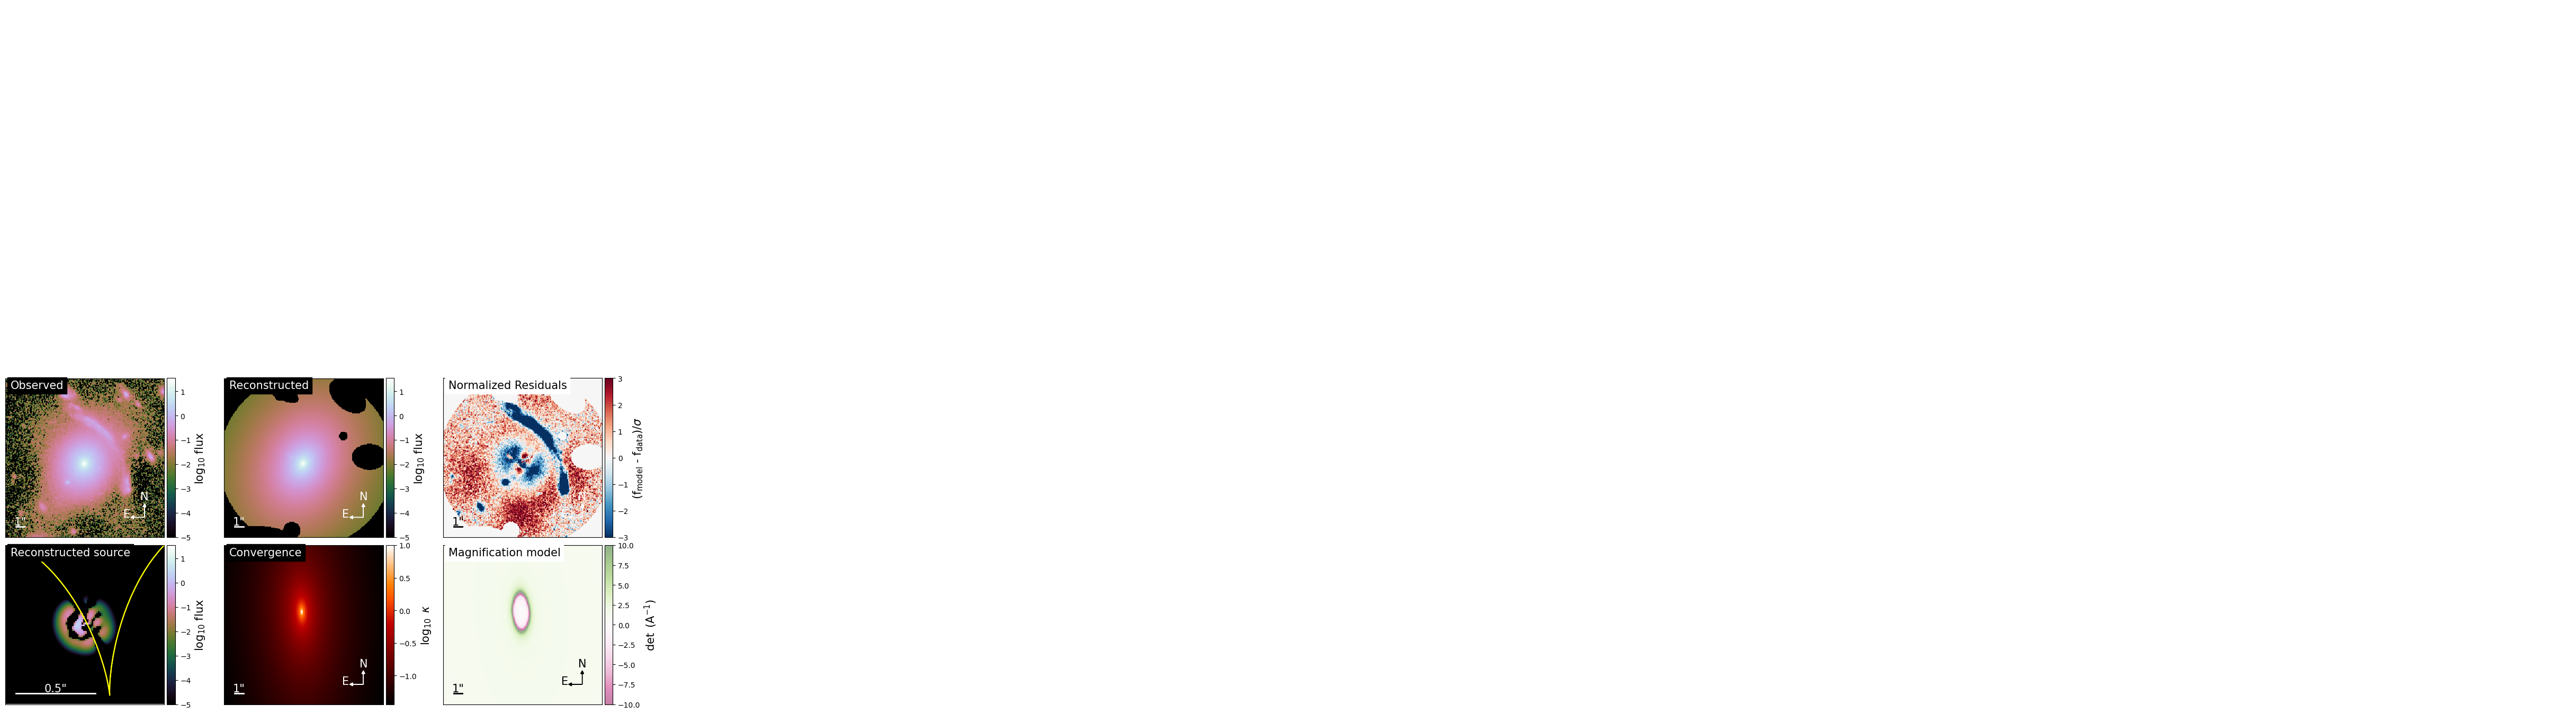

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


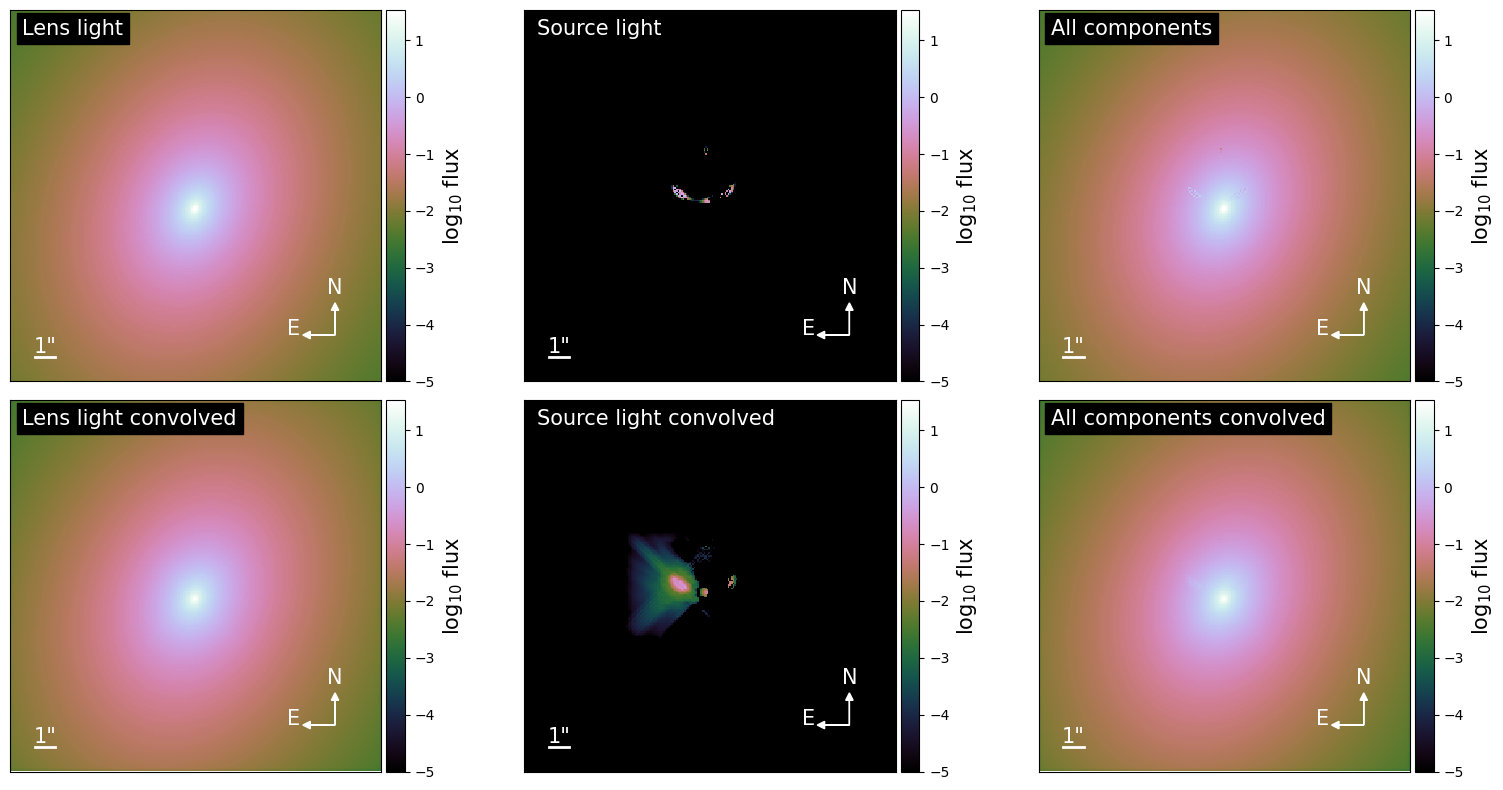

{'kwargs_lens': [{'theta_E': 1.464953441461582, 'gamma': 2.0711214114508714, 'e1': -0.41082065229939746, 'e2': 0.022727625782002506, 'center_x': 0.2940856425469929, 'center_y': 1.4129468684053734}, {'gamma1': -0.000529703436645998, 'gamma2': -0.027069038105625064, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 18472.942857920974, 'R_sersic': 0.008058337669628613, 'n_sersic': 1.0, 'e1': 0.34214762400517607, 'e2': -0.25564231736186765, 'center_x': 0.4007921372199501, 'center_y': 0.8383087318940491}, {'amp': array([  1107.49018777,  13104.9752083 ,    527.6997974 ,  13000.33322016,
        -5001.24369865,   2926.10875657,  -3156.6490065 ,  -7333.49550519,
        -4001.47431977,  -1722.14566543, -13447.45753531,  -7362.73779365,
        -7702.9842612 ,   -473.61344994,  -2343.61123602,  -9414.31389011,
        -4077.44278714,  -4628.19817138,   3689.34695753,    765.86820298,
         1716.8577016 ,   1205.38715322,   -285.04204275,    329.5183254 ,
         4303.59919472,   3480.4188

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)